In [1]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Calibration
## Preparation of input data
Synthesise LoS columns with optimal paths from the model

In [2]:
input_path = '../input/transport_demand/'
model_path = '../model/'

In [3]:
# Load StepModel with LOS table...
sm = stepmodel.read_json(model_path + 'de_pt_access_egress')
pt = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
sm.pt_los = pt.pt_los
sm.car_los = car.car_los

In [5]:
# Load calibration dataset
trips = pd.read_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')
print(len(trips.index))

96028


In [6]:
trips = trips.drop(columns='Unnamed: 0')
trips.reset_index(drop=True, inplace=True)
#trips.head()

In [7]:
# Replace LAU codes with NUTS IDs
if not str(trips.loc[0, 'origin']).startswith('DE'):
    z = stepmodel.read_json(model_path + 'de_zones')
    lau_nuts_dict = z.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    trips['origin'] = trips['origin'].astype(str).map(lau_nuts_dict)
    trips['destination'] = trips['destination'].astype(str).map(lau_nuts_dict)

    # Drop all other trips
    trips = trips.loc[(trips['origin'].notna()) & (trips['destination'].notna())]
    len(trips.index)

In [8]:
trips.loc[trips.isna().any(axis=1)]

,origin,VBGEM_SO,destination,VBGEM_ZO,SKTYP,distance,distance_routed,duration,purpose,mode,...,mode_affinity,dist_train_origin,dist_bus_origin,dist_train_destination,dist_bus_destination,W_DETAIL,W_SO2,urbanisation,purpose_vp,mode_model


In [9]:
len(trips)

95576

## Distance
As survey responds regarding trip distance are not accurate, add the network model's length.

In [10]:
# Add a length column based on the shortest
# road connection in the network model (in km)
car_len = sm.car_los.sort_values('time').groupby(
    ['origin', 'destination']).first()['length'].to_dict()
trips['length'] = [car_len[a]/1000 if a in car_len.keys() else np.nan
                   for a in tuple(zip(trips['origin'], trips['destination']))]

In [11]:
# Some OD pairs might not be in the volumes table
# which results in missing values for the calibration dataset
k = len(trips.loc[trips['length'].isna()])
print(k)
print(k / len(trips))

16
0.00016740604335816522


In [12]:
# Drop trips without time reference if its share is insignificant
assert k/len(trips)<0.01
trips = trips.loc[trips['length'].notna()]

<AxesSubplot:xlabel='length', ylabel='distance'>

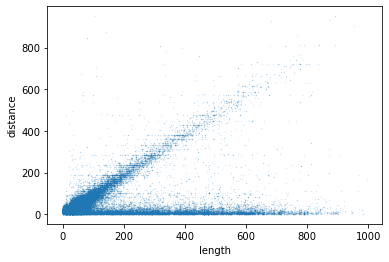

In [13]:
# Comparison of the model's length and the survey's distance
trips.plot.scatter(x='length', y='distance', s=.1, alpha=.2)

In [14]:
# We can validate it with the routed distances from MiD.
bins = [0, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000]
labels = [1,2,3,4,5,6,7,8,9]
trips['length_routed'] = pd.cut(trips['length'], bins=bins, labels=labels)
# How many trips have mismatching routed distances?
len(trips.loc[(trips['distance_routed']!=trips['length_routed'])&(trips['distance_routed']<=9)])

37818

In [15]:
# Check the routed distance in the validation dataset
trips['distance_routed_2'] = pd.cut(trips['distance'], bins=bins, labels=labels)
# How many trips have mismatching routed distances?
len(trips.loc[(trips['distance_routed']!=trips['distance_routed_2'])&(trips['distance_routed']<=9)])

29051

## Time

All imputated time columns are needed for the MLE model. They do not replace duration statements in the survey but complement each trip with alternative travel times in modes that were not used for this trip.

In [16]:
# IMPORTANT: Make sure pt_los time is converted to minutes
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 60
elif sm.pt_los['time'].mean() < 10:
    sm.pt_los['time'] = sm.pt_los['time'] * 60
sm.pt_los['time'].mean()

353.2440980396437

In [17]:
# IMPORTANT: Make sure car_los time is converted to minutes
if sm.car_los['time'].mean() > 3600:
    sm.car_los['time'] = sm.car_los['time'] / 60
elif sm.car_los['time'].mean() < 10:
    sm.car_los['time'] = sm.car_los['time'] * 60
sm.car_los['time'].mean()

270.810843411065

In [18]:
# Create dictionaries from LoS tables
# Take the mean of 2 fastest trips for PT
car_dict = sm.car_los.sort_values('time').groupby(
    ['origin', 'destination']).first()['time'].to_dict()
pt_dict = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_type']).nth([0,1]).groupby(
    ['origin', 'destination', 'route_type']).agg({'time': 'mean'}).to_dict()['time']

In [19]:
# Car
# Directly from car LoS table
trips['time_car'] = [car_dict[a] if a in car_dict.keys() else np.nan
                     for a in tuple(zip(trips['origin'], trips['destination']))]
assert len(trips.loc[trips['time_car'].isna()])==0

In [20]:
# PT (incl. walk)
for t in sm.pt_los['route_type'].unique():
    trips['route_type'] = t
    trips['time_' + t] = [pt_dict[a]
        if a in pt_dict.keys() else np.inf
        for a in tuple(zip(trips['origin'], trips['destination'], trips['route_type']))]
trips.drop('route_type', axis=1, inplace=True)

## Validation of model connectivity

The network model might not provide paths between all OD pairs for all modes. Moreover, the survey might contain erronous statements about trip distance, duration or even origin and destination cell.

In [21]:
# Drop trips where speeds are unrealistic
max_speeds = {1: 150, 2: 200, 3: 50, 4: 100, 5: 1000, 6: 150, 7: 40}
for mode, max_speed in max_speeds.items():
    mask = (trips['mode_model']==mode)&((trips['length']/trips['duration'])>max_speed)
    print('{}: dropped {} observations ({} %)'.format(
        mode, len(trips.loc[mask]), len(trips.loc[mask])/len(trips.loc[trips['mode_model']==mode])*100))
    trips = trips.loc[~(mask)]

1: dropped 0 observations (0.0 %)
2: dropped 0 observations (0.0 %)
3: dropped 0 observations (0.0 %)
4: dropped 0 observations (0.0 %)
5: dropped 0 observations (0.0 %)
6: dropped 10 observations (0.012021831646269625 %)
7: dropped 26 observations (2.425373134328358 %)


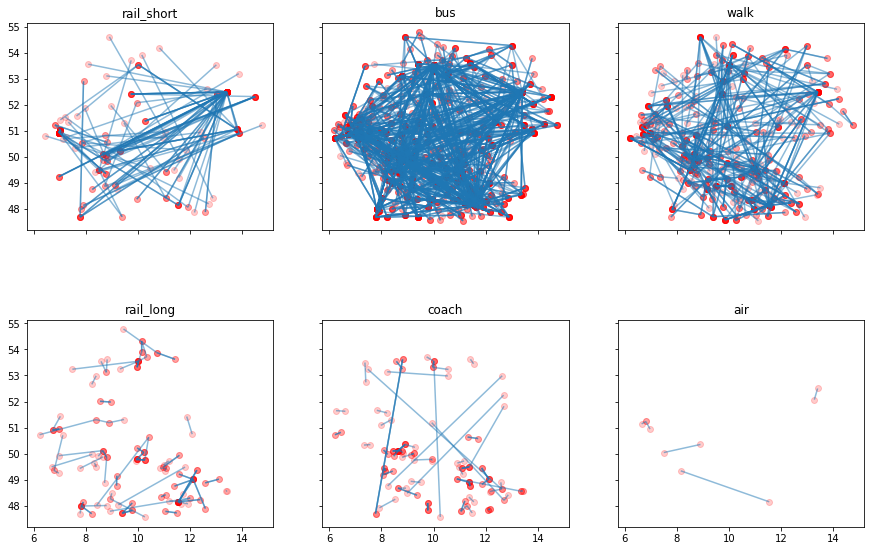

In [22]:
# Check observations without model connection
mode_dict = {1: 'rail_short', 2: 'rail_long',
             3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
fix, axs = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all', figsize=(15,10))
for m, row, col in [(1,0,0), (2,1,0), (3,1,1), (4,0,1), (5,1,2), (7,0,2)]:
    t = trips.loc[((trips['mode_model']==m) & (trips['time_'+mode_dict[m]]==np.inf))]
    lines = gpd.GeoDataFrame({'mode': [m]*len(t),
                              'geometry': [geometry.LineString([sm.centroids.loc[o, 'geometry'].coords[0],
                                                                sm.centroids.loc[d, 'geometry'].coords[0]])
                                           for o,d in zip(t['origin'], t['destination'])]},
                             crs=sm.epsg)
    lines.plot(alpha=.5, ax=gpd.GeoDataFrame(sm.centroids,crs=sm.epsg).loc[
        list(t['origin'])+list(t['destination']), 'geometry'].plot(
            alpha=.2, color='red', ax=axs[row,col]))
    axs[row,col].set_title(mode_dict[m])

In [23]:
# Mean distance of not assigned non-motorised trips
trips.loc[((trips['mode_model']==7) & (trips['time_walk']==np.inf)), 'length'].mean()

271.496347639485

In [24]:
# Mean distance of all non-motorised trips
trips.loc[(trips['mode_model']==7), 'length'].mean()

135.2163881453155

In [25]:
# Assign cycling speed
mask = ((trips['mode_model']==7) & (trips['time_walk']==np.inf))
trips.loc[mask, 'time_walk'] = trips.loc[mask, 'length'] / 17 # km/h

In [26]:
# Aggregate rail
# The fastest route determines time of rail service
trips['time_rail'] = [min(t_s, t_l) for t_s, t_l in zip(
    trips['time_rail_short'], trips['time_rail_long'])]

In [27]:
# Aggregate road PT
trips['time_road'] = [min(t_s, t_l) for t_s, t_l in zip(
    trips['time_bus'], trips['time_coach'])]

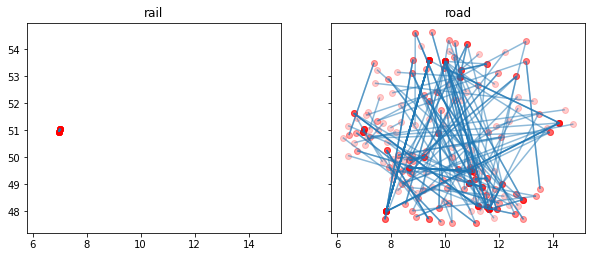

In [28]:
# Check observations without model connection again aggregated
fix, axs = plt.subplots(nrows=1, ncols=2, sharex='all', sharey='all', figsize=(10,5))
for m, modes, row, col in [('rail',[1,2],0,0), ('road',[3,4],0,1)]:
    t = trips.loc[((trips['mode_model'].isin(modes)) & (trips['time_'+m]==np.inf))]
    lines = gpd.GeoDataFrame({'mode': [m]*len(t),
                              'geometry': [geometry.LineString([sm.centroids.loc[o, 'geometry'].coords[0],
                                                                sm.centroids.loc[d, 'geometry'].coords[0]])
                                           for o,d in zip(t['origin'], t['destination'])]},
                             crs=sm.epsg)
    lines.plot(alpha=.5, ax=gpd.GeoDataFrame(sm.centroids,crs=sm.epsg).loc[
        list(t['origin'])+list(t['destination']), 'geometry'].plot(
            alpha=.2, color='red', ax=axs[col]))
    axs[col].set_title(m)

In [29]:
# Mean distance of not assigned road PT trips
trips.loc[((trips['mode_model'].isin([3,4])) & (trips['time_road']==np.inf)), 'length'].mean()

423.3598723404255

In [30]:
# Save missing trips
t = trips.iloc[0:0]
for name, m in [('rail',[1,2]), ('road',[3,4])]:
    t = t.append(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
t.to_csv(input_path + 'missing_trips.csv')

In [31]:
# How many observations have no connection?
m_dict = {v:k for k,v in mode_dict.items()}
for t in m_dict.keys():
    try:
        k = len(trips.loc[((trips['mode_model']==m_dict[t]) & (trips['time_'+t]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            t, k, k/len(trips.loc[trips['mode_model']==m_dict[t]])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(t))

rail_short: 134 observations have no model connection (2.1049324536600693 percent)
rail_long: 95 observations have no model connection (8.683729433272395 percent)
coach: 93 observations have no model connection (35.907335907335906 percent)
bus: 1425 observations have no model connection (40.19746121297602 percent)
air: 5 observations have no model connection (11.904761904761903 percent)
car: 0 observations have no model connection (0.0 percent)
walk: 0 observations have no model connection (0.0 percent)


In [32]:
# How many observations have no connection? (aggregated)
for name, m in {'rail': [1,2], 'road': [3,4], 'air': [5]}.items():
    try:
        k = len(trips.loc[((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))])
        print('{}: {} observations have no model connection ({} percent)'.format(
            name, k, k/len(trips.loc[trips['mode_model'].isin(m)])*100))
    except ZeroDivisionError:
        print('{} mode has no observations'.format(name))

rail: 24 observations have no model connection (0.32171581769436997 percent)
road: 235 observations have no model connection (6.177707676130389 percent)
air: 5 observations have no model connection (11.904761904761903 percent)


Dropping too high percentage of PT observations will skew the calibration towards the car. Thus, the same share of car, bus, coach trips from the same distance categories should be dropped as well, if the percentage is significant. Air transport has so few observations that correct calibration of air trips is not possible with dataset anyways.

In case of public road transport, there might be private charter buses included into the calibration dataset, which cannot be included into the network model. A closer look at missing trips reveals only long-distance travel with purposes shopping or education, which could well be organised shopping trips or class trips, respectively. Thus, we have to drop these trips.

If there are only few missing rail connections, they can be added manually in the mode choice notebook.

In [33]:
# Drop missing trips
for name, m in {'road': [3,4], 'air': [5]}.items():
    trips = trips.loc[~((trips['mode_model'].isin(m)) & (trips['time_'+name]==np.inf))]
trips.shape

(95284, 36)

In [34]:
# Add this rail connection between DEA24 and DEA23 manually
mask = ((trips['mode_model'].isin([1,2])) & (trips['time_rail']==np.inf))
trips.loc[mask, 'time_rail'] = trips.loc[mask, 'duration']
print(trips.loc[mask, 'time_rail'].mean())
print(trips.loc[mask, 'distance'].mean())

50.875
19.465


In [35]:
'''# Replace observed time for the mode of choice
mode_col_map = {1: 'time_rail_short', 2: 'time_rail_long',
                3: 'time_coach', 4: 'time_bus', 5: 'time_air',
                6: 'time_car', 7: 'time_walk'}
for mode, col in mode_col_map.items():
    mask = (trips['mode_model']==mode)
    trips.loc[mask, col] = trips.loc[mask, 'duration']
trips.loc[trips['mode_model']==1, 'time_rail'] = \
    trips.loc[trips['mode_model']==1, 'time_rail_short']
trips.loc[trips['mode_model']==2, 'time_rail'] = \
    trips.loc[trips['mode_model']==2, 'time_rail_long']
trips.loc[trips['mode_model']==3, 'time_road'] = \
    trips.loc[trips['mode_model']==3, 'time_coach']
trips.loc[trips['mode_model']==4, 'time_road'] = \
    trips.loc[trips['mode_model']==4, 'time_bus']'''
print('Deprected')

Deprected


In [35]:
trips.replace({np.inf: np.nan}).groupby('mode_model').agg(
    {'time_rail_long': 'mean', 'time_rail_short': 'mean', 'time_rail': 'mean',
     'time_coach': 'mean', 'time_bus': 'mean', 'time_road': 'mean',
     'time_air': 'mean', 'time_car': 'mean', 'time_walk': 'mean'})

,time_rail_long,time_rail_short,time_rail,time_coach,time_bus,time_road,time_air,time_car,time_walk
mode_model,,,,,,,,,
1,120.716436,81.044341,78.740669,157.664859,89.915479,118.338912,270.285456,62.406773,81.333973
2,183.498532,221.039118,171.578260,256.304338,111.303086,244.357061,257.448883,178.211030,95.979710
3,166.748255,139.009077,127.523975,246.130924,87.367994,188.781284,260.983013,115.483128,85.318654
4,169.367020,112.513272,108.052031,227.355881,77.233781,156.955679,261.565522,89.248526,68.781453
5,303.757658,491.184936,303.757658,441.712097,NaN,441.712097,194.555631,373.326577,NaN
6,170.930284,114.579935,109.259329,213.842475,92.252491,151.715068,319.743908,82.134057,85.585069
7,197.003746,132.258392,122.783078,252.145932,75.935041,165.010551,300.212421,103.970873,46.157053


## Price
For model calibration we need cost data for each trip. This column is generated using the travel cost function from the model's LoS formulation. For PT, the type of ticket or subscription is being considered.

In [36]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [37]:
trips['cost_walk'] = 0 # foot and bicycle trips are free of monetary cost

In [38]:
# The same assumptions for car travel as in the car LoS generation (prep30)
vc_car = 0.00011439257425742574 # in €/m
parking_cost = {1: 5, 2: 0, 3: 0} # cost depending on urbanisation degree
# Car, see prep30_los_road
trips['cost_car'] = [monetary_cost(d*1000, 1, vc_car, 0,0, parking_cost[u], 1, n) + 0.8 * t/60
                     for d, n, u, t in zip(trips['length'], trips['n_persons'],
                                           trips['urbanisation'], trips['duration'])]

In [39]:
# Ticket type determines the trip cost
# Assume this dict with factors
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}

In [40]:
# Rail short-distance, see prep31
# Trips with subscriptions are free of charge
trips['cost_rail_short'] = [(d*0.233 + 1.468) * ticket_dict[t]
                            for d, t in zip(trips['length'], trips['ticket_type'])]

In [41]:
# Rail long-distance
# Take prices from the model (validated)
# Choose the fastest routes as reference
rail_dict = sm.pt_los.sort_values('time').loc[
    sm.pt_los['route_type']=='rail_long'
].groupby(['origin', 'destination']).nth([0,1]).groupby(
    ['origin', 'destination']).agg({'price': 'mean'}).to_dict()['price']
trips['cost_rail_long'] = [rail_dict[(o,d)] if (o,d) in rail_dict.keys()
                           else np.inf for o, d in zip(trips['origin'], trips['destination'])]

In [42]:
# How many rail long prices do not exist while short prices do?
len(trips.loc[(trips['cost_rail_long']==np.inf)&(trips['cost_rail_short']!=np.inf)])

47039

In [43]:
# Replace infinite values for rail long with rail short prices
#trips.loc[trips['cost_rail_long']==np.inf, 'cost_rail_long'] = \
#    trips.loc[trips['cost_rail_long']==np.inf, 'cost_rail_short']

In [44]:
# Aggregate rail: Take cost of the alternative that
# has a time closer to the observed time
trips['diff_rail_short'] = (trips['time_rail_short'] - trips['duration']).abs()
trips['diff_rail_long'] = (trips['time_rail_long'] - trips['duration']).abs()
trips['cost_rail'] = [c_l if d_l<d_s else c_s
                      for d_s, d_l, c_s, c_l in zip(
    trips['diff_rail_short'], trips['diff_rail_long'],
    trips['cost_rail_short'], trips['cost_rail_long'])]
trips.drop(['diff_rail_short', 'diff_rail_long'], axis=1, inplace=True)
trips.loc[trips['mode_model']==1, 'cost_rail'] = \
    trips.loc[trips['mode_model']==1, 'cost_rail_short']
trips.loc[trips['mode_model']==2, 'cost_rail'] = \
    trips.loc[trips['mode_model']==2, 'cost_rail_long']

In [45]:
# Add price caps as in prep31
trips['cost_rail'] = np.clip(trips['cost_rail'], 0, 139)
trips['cost_rail_long'] = np.clip(trips['cost_rail_long'], 19, 139)
trips['cost_rail_short'] = np.clip(trips['cost_rail_short'], 0, 42)

In [46]:
# Bus and tram
# Trip cost depend on the ticket type and regional type
# See prep31 for prices
region_dict = {1: 2.74, 2: 4, 3: 4}
trips['cost_bus'] = [region_dict[r] * ticket_dict[t] for r,t in zip(
    trips['urbanisation'], trips['ticket_type'])]

In [47]:
# Coach
# see prep31
trips['cost_coach'] = trips['length'].apply(
    lambda d: monetary_cost(d, 1, 0.0566, 0, 0, 0, 0, 1))
trips['cost_coach'] = np.clip(trips['cost_coach'], 5, 60)

In [48]:
# Aggregate the same way as rail
trips['diff_bus'] = (trips['time_bus'] - trips['duration']).abs()
trips['diff_coach'] = (trips['time_coach'] - trips['duration']).abs()
trips['cost_road'] = [c_l if d_l<d_s else c_s
                      for d_s, d_l, c_s, c_l in zip(
    trips['diff_bus'], trips['diff_coach'],
    trips['cost_bus'], trips['cost_coach'])]
trips.drop(['diff_bus', 'diff_coach'], axis=1, inplace=True)
trips.loc[trips['mode_model']==4, 'cost_road'] = \
    trips.loc[trips['mode_model']==4, 'cost_bus']
trips.loc[trips['mode_model']==3, 'cost_road'] = \
    trips.loc[trips['mode_model']==3, 'cost_coach']

In [49]:
# Air, see prep31
# Take the fastest connections from the model
air_dict = sm.pt_los.loc[sm.pt_los['route_type']=='air'
                        ].sort_values('time').groupby(
    ['origin', 'destination']).first()['price'].to_dict()

In [50]:
trips['cost_air'] = [air_dict[(o,d)] if (o,d) in air_dict.keys() else np.inf
                     for o, d in zip(trips['origin'], trips['destination'])]
trips.loc[trips['cost_air'].isna(), 'cost_air'] = np.inf

In [51]:
# Summary
trips.groupby('mode_model').agg({'cost_car': 'mean', 'cost_coach': 'mean',
                                 'cost_bus': 'mean', 'cost_air': 'mean',
                                 'cost_rail_short': 'mean',
                                 'cost_rail_long': 'mean',
                                 'cost_rail': 'mean', 'cost_road': 'mean'})

,cost_car,cost_coach,cost_bus,cost_air,cost_rail_short,cost_rail_long,cost_rail,cost_road
mode_model,,,,,,,,
1,10.453166,6.395397,1.428479,inf,6.790892,82.694388,8.761144,3.679183
2,27.660848,14.908978,1.941190,inf,22.850719,44.415284,44.415284,12.254255
3,12.906585,10.114157,2.175385,inf,17.754536,73.463989,23.433290,10.114157
4,13.527095,8.695262,1.708297,inf,9.870786,85.951612,15.234919,1.708297
5,47.507971,32.665270,2.303027,71.526486,32.918919,61.648965,61.648965,25.999216
6,10.493954,7.668265,2.945233,inf,15.728574,82.953709,17.300567,5.501792
7,14.390903,9.778140,2.534444,inf,15.143506,81.293045,19.369477,7.125406


Text(0, 0.5, 'price [EUR]')

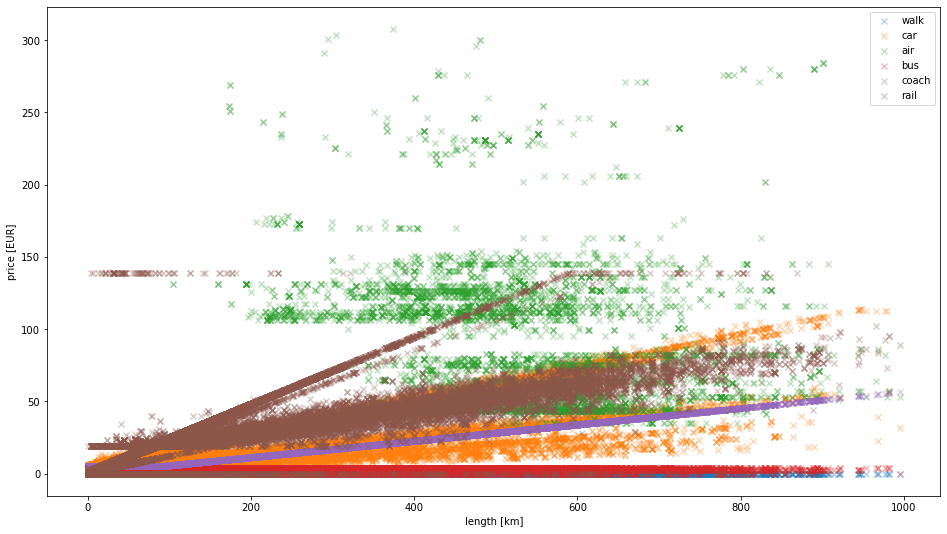

In [52]:
modes = [#('rail_long', 2), ('rail_short', 1),
         ('rail',1), ('coach',3), ('bus',4), ('air',5), ('car',6), ('walk',7)]
fig, ax = plt.subplots(figsize=(16,9))
for m, i in modes[::-1]:
    t = trips#.loc[trips['mode_model']==i].copy()
    plt.scatter(t['length'], t['cost_'+m], marker='x', alpha=.3, label=m)
plt.legend()
ax.set_xlabel('length [km]')
ax.set_ylabel('price [EUR]')

## Accessibility
Another important variable for the mode choice model is the accessibility of transport modes. Cars are highly accessible (1), only if there is one available. We apply the formula from the model. 
It considers the distance to the next train/bus stop from the start and end position.

In [53]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) inverse weight of distances
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [54]:
# The maximum accessibility for foot, bicycle and car is 1
trips['accessibility_walk'] = 1
trips['accessibility_car'] = trips['car_avail'].replace({9:0})

In [55]:
# Rail
# People don't differentiate between long and short distance accessibility
# if there is at least one railway station nearby
trips['accessibility_rail'] = [accessibility(o, d) for o, d in zip(
    trips['dist_train_origin'], trips['dist_train_destination'])]

In [56]:
# Bus
trips['accessibility_bus'] = [accessibility(o, d) for o, d in zip(
    trips['dist_bus_origin'], trips['dist_bus_destination'])]

In [57]:
# Coach
# Assume: It has the same accessibility as rail
trips['accessibility_coach'] = trips['accessibility_rail']

In [58]:
# Air
# Take the model's accessibility from the shortest path
air_dict = sm.pt_los.sort_values('length').loc[
    sm.pt_los['route_type']=='air'].groupby(
    ['origin', 'destination']).first()['accessibility'].to_dict()

In [59]:
trips['accessibility_air'] = [air_dict[(o,d)]
                              if (o,d) in air_dict.keys() else 0
                              for o, d in zip(trips['origin'], trips['destination'])]

In [60]:
# Summary
trips.groupby('mode_model').agg(
    {'accessibility_car': 'mean', 'accessibility_rail': 'mean',
     'accessibility_coach': 'mean', 'accessibility_bus': 'mean',
     'accessibility_air': 'mean'})

,accessibility_car,accessibility_rail,accessibility_coach,accessibility_bus,accessibility_air
mode_model,,,,,
1,0.809142,0.711342,0.711342,0.756692,0.014246
2,0.742230,0.701691,0.701691,0.769241,0.102796
3,0.799180,0.551230,0.551230,0.643852,0.060337
4,0.828872,0.583714,0.583714,0.700917,0.031385
5,0.972973,0.162162,0.162162,0.235135,0.234884
6,0.985849,0.618105,0.618105,0.733829,0.024103
7,0.889101,0.357792,0.357792,0.417973,0.043807


In [61]:
trips[['accessibility_car', 'accessibility_rail', 'accessibility_coach',
       'accessibility_bus', 'accessibility_air']].mean()

accessibility_car      0.964223
accessibility_rail     0.620888
accessibility_coach    0.620888
accessibility_bus      0.730723
accessibility_air      0.024993
dtype: float64

### Save calibration dataset

In [62]:
trips.drop(['length_routed', 'distance_routed_2'], axis=1, inplace=True)

In [63]:
trips.loc[trips.isna().any(axis=1)]

,origin,VBGEM_SO,destination,VBGEM_ZO,SKTYP,distance,distance_routed,duration,purpose,mode,...,cost_bus,cost_coach,cost_road,cost_air,accessibility_walk,accessibility_car,accessibility_rail,accessibility_bus,accessibility_coach,accessibility_air


In [64]:
trips.to_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')